Files already downloaded and verified


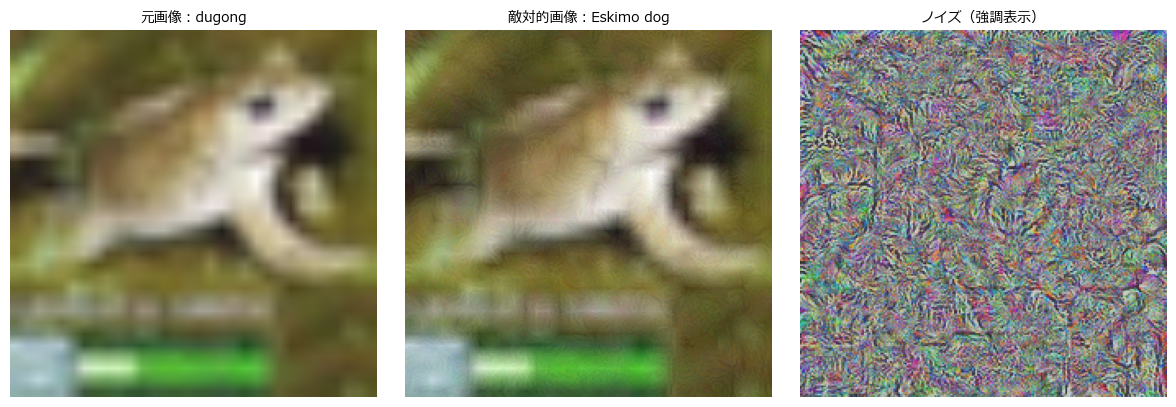


--- 元画像の予測（Top-5） ---
1. dugong (8.51%)
2. milk can (7.34%)
3. whiskey jug (4.54%)
4. gazelle (3.36%)
5. chiffonier (2.74%)

--- 敵対的画像の予測（Top-5） ---
1. Eskimo dog (65.76%)
2. malamute (18.61%)
3. Siberian husky (15.62%)
4. timber wolf (0.00%)
5. white wolf (0.00%)


In [2]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import resnet18
import urllib.request

# 日本語フォントの設定（Windows例：メイリオ）
plt.rcParams['font.family'] = 'Meiryo'  # 他に 'IPAexGothic' などでも可



# ----- 1. デバイス設定 -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- 2. CIFAR-10データセット（リサイズ） -----
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet18用
    transforms.ToTensor()
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

# ----- 3. 学習済みResNet18（ImageNet） -----
model = resnet18(pretrained=True).to(device)
model.eval()

# ----- 4. ImageNetラベル読み込み -----
LABELS_URL = 'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt'
with urllib.request.urlopen(LABELS_URL) as f:
    imagenet_labels = [line.strip().decode('utf-8') for line in f.readlines()]

# ----- 5. PGD攻撃関数 -----
def pgd_attack(model, images, labels, eps=0.03, alpha=0.005, iters=10):
    images = images.clone().detach().to(device)
    ori_images = images.clone().detach()
    labels = labels.to(device)

    for _ in range(iters):
        images.requires_grad = True
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        grad = images.grad.data

        adv_images = images + alpha * grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach()

    return images

# ----- 6. 可視化関数 -----
def imshow(img_tensor, title=''):
    npimg = img_tensor.cpu().numpy()
    npimg = np.transpose(npimg, (1, 2, 0))  # CHW→HWC
    plt.imshow(np.clip(npimg, 0, 1))
    plt.title(title, fontsize=10)
    plt.axis('off')

# ----- 7. 予測ラベルと確率表示 -----
def print_top_predictions(probs, title):
    top5_prob, top5_idx = torch.topk(probs, 5)
    print(f"\n--- {title} ---")
    for i in range(5):
        idx = top5_idx[0][i].item()
        prob = top5_prob[0][i].item()
        label = imagenet_labels[idx]
        print(f"{i+1}. {label} ({prob:.2%})")

# ----- 8. 攻撃実行 + 結果可視化 -----
# 1枚の画像取得
data_iter = iter(testloader)
images, labels = next(data_iter)
images = images.to(device)
labels = labels.to(device)

# モデル予測（クリーン画像）
outputs_clean = model(images)
probs_clean = torch.softmax(outputs_clean, dim=1)
pred_clean = outputs_clean.argmax(dim=1)

# PGD攻撃
adv_images = pgd_attack(model, images, labels, eps=0.03, alpha=0.005, iters=10)
outputs_adv = model(adv_images)
probs_adv = torch.softmax(outputs_adv, dim=1)
pred_adv = outputs_adv.argmax(dim=1)

# 差分（ノイズ）画像
delta = adv_images - images

# 可視化
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
imshow(images[0], f"元画像：{imagenet_labels[pred_clean.item()]}")

plt.subplot(1, 3, 2)
imshow(adv_images[0], f"敵対的画像：{imagenet_labels[pred_adv.item()]}")

plt.subplot(1, 3, 3)
imshow(delta[0] * 10 + 0.5, "ノイズ（強調表示）")

plt.tight_layout()
plt.show()

# 予測ラベル出力
print_top_predictions(probs_clean, "元画像の予測（Top-5）")
print_top_predictions(probs_adv, "敵対的画像の予測（Top-5）")
